In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
def wrangle(path):
    df = pd.read_csv(path)
    df.drop(columns=["Name", "Cabin"], inplace=True)
    df["VIP"] = df["VIP"].astype("bool")
    df["CryoSleep"] = df["CryoSleep"].astype("bool")
    home_planet = pd.get_dummies(df["HomePlanet"], drop_first=True)
    destination = pd.get_dummies(df["Destination"], drop_first=True)
    df = pd.concat([df, home_planet, destination], axis=1)
    df.drop(columns=["HomePlanet", "Destination"], inplace=True)
    return df

In [3]:
df = wrangle("/kaggle/input/spaceship-titanic/train.csv")
df.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Europa,Mars,PSO J318.5-22,TRAPPIST-1e
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0,0,1
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0,0,1
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,0,0,1
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0,0,1
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0,0,1


In [4]:
df.shape

(8693, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Age            8514 non-null   float64
 3   VIP            8693 non-null   bool   
 4   RoomService    8512 non-null   float64
 5   FoodCourt      8510 non-null   float64
 6   ShoppingMall   8485 non-null   float64
 7   Spa            8510 non-null   float64
 8   VRDeck         8505 non-null   float64
 9   Transported    8693 non-null   bool   
 10  Europa         8693 non-null   uint8  
 11  Mars           8693 non-null   uint8  
 12  PSO J318.5-22  8693 non-null   uint8  
 13  TRAPPIST-1e    8693 non-null   uint8  
dtypes: bool(3), float64(6), object(1), uint8(4)
memory usage: 534.9+ KB


In [6]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Europa,Mars,PSO J318.5-22,TRAPPIST-1e
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.245140,0.202347,0.091568,0.680433
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.430195,0.401772,0.288432,0.466336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,0.000000,0.000000,0.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df["RoomService"].quantile([0.1, 0.9])

0.1      0.0
0.9    753.0
Name: RoomService, dtype: float64

<AxesSubplot:>

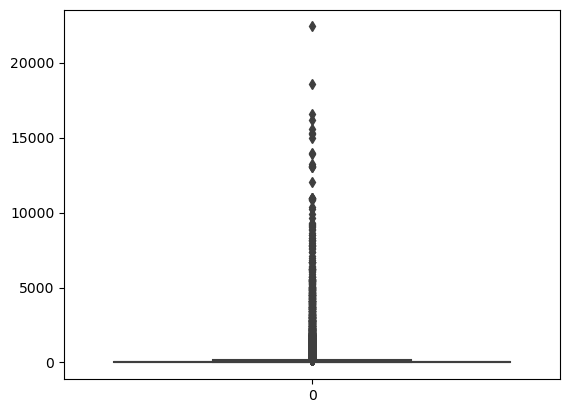

In [8]:
sns.boxplot(df["Spa"])

<AxesSubplot:>

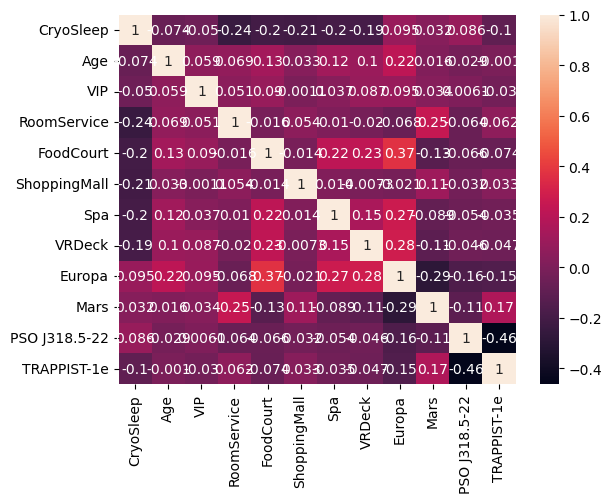

In [9]:
#to check if there are any feature depend on an another feature
cor = df.drop(columns="Transported").corr()
sns.heatmap(cor, annot=True)

In [10]:
df["Transported"].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

In [11]:
acc_baseline = df["Transported"].value_counts(normalize=True).max()
print("Baseline Accuracy: {:.03f}".format(acc_baseline))

Baseline Accuracy: 0.504


In [12]:
target = "Transported"
X = df.drop(columns=[target, "PassengerId"])
y= df[target]
print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

X Shape:  (8693, 12)
y Shape:  (8693,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (6954, 12)
X_test Shape:  (1739, 12)
y_train Shape:  (6954,)
y_test Shape:  (1739,)


In [14]:
rf_clf = make_pipeline(SimpleImputer(), RandomForestClassifier())
rf_clf

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [15]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__max_depth": range(10, 51, 10),
    "randomforestclassifier__n_estimators": range(25,101,25)
}

In [16]:
model_rf = GridSearchCV(rf_clf, param_grid=params, n_jobs=-1, cv=5, verbose=1)

In [17]:
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 51, 10),
                         'randomforestclassifier__n_estimators': range(25, 101, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [18]:
model_rf.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'median'}

In [19]:
model_rf.score(X_test, y_test)

0.7878090856814262

In [20]:
Test_data = wrangle("/kaggle/input/spaceship-titanic/test.csv")
Test_data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Europa,Mars,PSO J318.5-22,TRAPPIST-1e
0,0013_01,True,27.0,False,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1,0018_01,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,0,0,1
2,0019_01,True,31.0,False,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0021_01,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,1,0,0,1
4,0023_01,False,20.0,False,10.0,0.0,635.0,0.0,0.0,0,0,0,1


In [21]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   CryoSleep      4277 non-null   bool   
 2   Age            4186 non-null   float64
 3   VIP            4277 non-null   bool   
 4   RoomService    4195 non-null   float64
 5   FoodCourt      4171 non-null   float64
 6   ShoppingMall   4179 non-null   float64
 7   Spa            4176 non-null   float64
 8   VRDeck         4197 non-null   float64
 9   Europa         4277 non-null   uint8  
 10  Mars           4277 non-null   uint8  
 11  PSO J318.5-22  4277 non-null   uint8  
 12  TRAPPIST-1e    4277 non-null   uint8  
dtypes: bool(2), float64(6), object(1), uint8(4)
memory usage: 259.1+ KB


In [22]:
model_rf.predict(Test_data.drop(columns="PassengerId"))

array([ True, False,  True, ...,  True,  True,  True])

In [23]:
Test_data.PassengerId

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [24]:
pd.DataFrame({"Transported": model_rf.predict(Test_data.drop(columns="PassengerId"))}, index=Test_data.PassengerId
).to_csv("/kaggle/working/submission.csv")